# Combined Dataset

## Importing Combined Dataset

In [174]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import (accuracy_score,confusion_matrix,ConfusionMatrixDisplay)
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler

In [175]:
train_emoticon_df = pd.read_csv("datasets/train/train_emoticon.csv")
train_emoticon_X = train_emoticon_df['input_emoticon']
train_emoticon_Y = train_emoticon_df['label'].to_numpy()

valid_emoticon_df=pd.read_csv("datasets/valid/valid_emoticon.csv")
valid_emoticon_X = valid_emoticon_df['input_emoticon']
valid_emoticon_Y = valid_emoticon_df['label'].to_numpy()

In [176]:
# Load the dataset
data = np.load('datasets/train/train_feature.npz', allow_pickle=True)
train_deep_X = data['features']
train_deep_Y = data['label']

# Load validation set
valid_data = np.load('datasets/valid/valid_feature.npz', allow_pickle=True)
valid_deep_X = valid_data['features']
valid_deep_Y = valid_data['label']

## Taking % of Training Dataset

In [177]:
train_emoticon_X_100 = train_emoticon_X
train_emoticon_Y_100 = train_emoticon_Y
train_deep_X_100 = train_deep_X
train_emoticon_X_80, train_emoticon_X_20, train_deep_X_80, train_deep_X_20, train_emoticon_Y_80, train_emoticon_Y_20 = train_test_split(train_emoticon_X, train_deep_X, train_emoticon_Y, test_size=0.2, stratify=train_emoticon_Y, random_state=42)
train_emoticon_X_60, train_emoticon_X_40, train_deep_X_60, train_deep_X_40, train_emoticon_Y_60, train_emoticon_Y_40 = train_test_split(train_emoticon_X, train_deep_X, train_emoticon_Y, test_size=0.4, stratify=train_emoticon_Y, random_state=42)

## For 100% Training Data

### Feature Tansformation and encoding

#### For emoticon Dataset

##### Transformation

In [178]:
train_emoticon_X_data_100 = [list(input_str) for input_str in train_emoticon_X_100]
train_emoticon_X_data_100 = pd.DataFrame(train_emoticon_X_data_100)
train_emoticon_X_data_100 = train_emoticon_X_data_100.map(ord)
train_emoticon_X_data_100 = train_emoticon_X_data_100.astype(str)
train_emoticon_X_data_100 = train_emoticon_X_data_100.apply(lambda row: ' '.join(row.values), axis=1)
train_emoticon_X_data_100 = pd.DataFrame(train_emoticon_X_data_100, columns=['text'])

In [179]:
valid_emoticon_X_data_100 = [list(input_str) for input_str in valid_emoticon_X]
valid_emoticon_X_data_100 = pd.DataFrame(valid_emoticon_X_data_100)
valid_emoticon_X_data_100 = valid_emoticon_X_data_100.map(ord)
valid_emoticon_X_data_100 = valid_emoticon_X_data_100.astype(str)
valid_emoticon_X_data_100 = valid_emoticon_X_data_100.apply(lambda row: ' '.join(row.values), axis=1)
valid_emoticon_X_data_100 = pd.DataFrame(valid_emoticon_X_data_100, columns=['text'])

##### Embedding

In [180]:
train_df = train_emoticon_X_data_100
valid_df = valid_emoticon_X_data_100

combined_vocab = set()
train_df['tokens'] = train_df['text'].apply(lambda x: x.split())
combined_vocab.update(train_df['tokens'].explode().unique())
print(combined_vocab)
valid_df['tokens'] = valid_df['text'].apply(lambda x: x.split())
combined_vocab.update(valid_df['tokens'].explode().unique())
print(combined_vocab)
vocab_dict_100 = {word: idx for idx, word in enumerate(combined_vocab, start=1)}

def tokenize_data(df, vocab_dict_100):
    return df['tokens'].apply(lambda x: [vocab_dict_100[token] for token in x])

train_df['tokenized_text'] = tokenize_data(train_df, vocab_dict_100)
valid_df['tokenized_text'] = tokenize_data(valid_df, vocab_dict_100)
max_length = 13
train_padded = pad_sequences(train_df['tokenized_text'].tolist(), maxlen=max_length, padding='post')
valid_padded = pad_sequences(valid_df['tokenized_text'].tolist(), maxlen=max_length, padding='post')

embedding_size = 16
vocab_size = len(vocab_dict_100) + 1

input_layer = Input(shape=(max_length,), dtype='int32')
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_length, name='embedding_layer')(input_layer)
lstm_layer = LSTM(16, return_sequences=True)(embedding_layer)
dropout_layer = Dropout(0.2)(lstm_layer)
flatten_layer = Flatten()(dropout_layer)
dense_layer = Dense(8, activation='relu')(flatten_layer)
output_layer = Dense(1, activation='sigmoid')(dense_layer)

model_1_100 = Model(inputs=input_layer, outputs=output_layer, name='small_text_embedding_model')
model_1_100.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_1_100.summary()

train_labels = train_emoticon_Y_100
valid_labels = valid_emoticon_Y
model_1_100.fit(train_padded, train_labels, epochs=6, batch_size=2)

embedding_model_100 = Model(inputs=model_1_100.input, outputs=model_1_100.get_layer("embedding_layer").output)

train_embeddings = embedding_model_100.predict(train_padded)
valid_embeddings = embedding_model_100.predict(valid_padded)

{'128688', '128513', '128641', '128706', '128710', '128628', '128527', '128522', '128653', '128723', '128552', '128558', '128599', '128616', '128524', '128650', '128580', '128679', '128571', '128619', '128714', '128726', '128563', '128667', '128562', '128702', '128565', '128735', '128654', '128525', '128583', '128722', '128548', '128716', '128573', '128676', '128564', '128584', '128517', '128672', '128642', '128570', '128534', '128549', '128708', '128683', '128538', '128671', '128697', '128512', '128660', '128581', '128542', '128680', '128692', '128633', '128725', '128541', '128603', '128689', '128575', '128554', '128597', '128715', '128559', '128591', '128669', '128604', '128569', '128646', '128655', '128727', '128617', '128703', '128731', '128674', '128614', '128544', '128536', '128691', '128553', '128701', '128620', '128675', '128514', '128693', '128705', '128589', '128593', '128719', '128539', '128594', '128630', '128547', '128734', '128645', '128577', '128613', '128713', '128523',

/home/nishvaan/.local/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "small_text_embedding_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_layer (Embedding)     │ (None, 13, 16)         │         3,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 13, 16)         │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 13, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 208)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 8)              │         1,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,233 (28.25 KB)

 Trainable params: 7,233 (28.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/6
3540/3540 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.7340 - loss: 0.4632
Epoch 2/6
3540/3540 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9384 - loss: 0.1419
Epoch 3/6
3540/3540 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.9523 - loss: 0.1074
Epoch 4/6
3540/3540 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9610 - loss: 0.0967
Epoch 5/6
3540/3540 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9675 - loss: 0.0802
Epoch 6/6
3540/3540 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9692 - loss: 0.0721
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step


In [181]:
train_emoticon_X_flattened_100 = train_embeddings.reshape(train_embeddings.shape[0], -1)
valid_emoticon_X_flattened_100 = valid_embeddings.reshape(valid_embeddings.shape[0], -1)

train_emoticon_X_encoded_100=pd.DataFrame(train_emoticon_X_flattened_100)
valid_emoticon_X_encoded_100=pd.DataFrame(valid_emoticon_X_flattened_100)

##### Standardization

In [182]:
scaler_100 = StandardScaler()
train_emoticon_X_encoded_100 = scaler_100.fit_transform(train_emoticon_X_encoded_100)
valid_emoticon_X_encoded_100 = scaler_100.transform(valid_emoticon_X_encoded_100)

#### For Deep Feature Dataset

##### Feature Transformation

In [183]:
train_X_deep_flattened_100 = train_deep_X_100.reshape(train_deep_X_100.shape[0], -1)
valid_X_deep_flattened_100 = valid_deep_X.reshape(valid_deep_X.shape[0], -1)

print(train_X_deep_flattened_100.shape)

(7080, 9984)


##### Feature Reduction

In [184]:
pca_100 = PCA(n_components=100)
train_X_deep_flattened_100 = pca_100.fit_transform(train_X_deep_flattened_100)
valid_X_deep_flattened_100 = pca_100.transform(valid_X_deep_flattened_100)

### Model Training

In [185]:
model1_100 = SVC(C=0.1, degree=2, gamma='auto', kernel='rbf', probability=True)
model2_100 = SVC(C=100, degree=2, gamma='auto', kernel='rbf', probability=True)

model1_100.fit(train_emoticon_X_encoded_100, train_emoticon_Y_100)
model2_100.fit(train_X_deep_flattened_100, train_emoticon_Y_100)

P1 = model1_100.predict_proba(train_emoticon_X_encoded_100)[:, 1]
P2 = model2_100.predict_proba(train_X_deep_flattened_100)[:, 1]

meta_X_train = np.column_stack((P1,P2))

meta_model_100 = RandomForestClassifier()
meta_model_100.fit(meta_X_train, train_emoticon_Y_100)

RandomForestClassifier()

### Accuracy Checking

Validation Accuracy: 98.9775


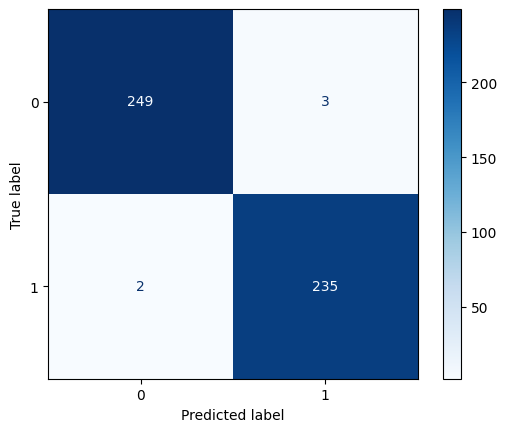

In [186]:
P1_valid = model1_100.predict_proba(valid_emoticon_X_encoded_100)[:, 1]
P2_valid = model2_100.predict_proba(valid_X_deep_flattened_100)[:, 1]

meta_X_valid = np.column_stack((P1_valid,P2_valid))

y_pred_valid_100 = meta_model_100.predict(meta_X_valid)

accuracy_100 = accuracy_score(valid_emoticon_Y, y_pred_valid_100)
conf_matrix = confusion_matrix(valid_emoticon_Y, y_pred_valid_100)

print(f"Validation Accuracy: {accuracy_100*100:.4f}")
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')

## For 80% Training Data

### Feature Transformation and Encoding

#### For Emoticon Dataset

##### Transformation

In [187]:
train_emoticon_X_data_80 = [list(input_str) for input_str in train_emoticon_X_80]
train_emoticon_X_data_80 = pd.DataFrame(train_emoticon_X_data_80)
train_emoticon_X_data_80 = train_emoticon_X_data_80.map(ord)
train_emoticon_X_data_80 = train_emoticon_X_data_80.astype(str)
train_emoticon_X_data_80 = train_emoticon_X_data_80.apply(lambda row: ' '.join(row.values), axis=1)
train_emoticon_X_data_80 = pd.DataFrame(train_emoticon_X_data_80, columns=['text'])

In [188]:
valid_emoticon_X_data_80 = [list(input_str) for input_str in valid_emoticon_X]
valid_emoticon_X_data_80 = pd.DataFrame(valid_emoticon_X_data_80)
valid_emoticon_X_data_80 = valid_emoticon_X_data_80.map(ord)
valid_emoticon_X_data_80 = valid_emoticon_X_data_80.astype(str)
valid_emoticon_X_data_80 = valid_emoticon_X_data_80.apply(lambda row: ' '.join(row.values), axis=1)
valid_emoticon_X_data_80 = pd.DataFrame(valid_emoticon_X_data_80, columns=['text'])

##### Embedding

In [189]:
train_df = train_emoticon_X_data_80
valid_df = valid_emoticon_X_data_80

combined_vocab = set()
train_df['tokens'] = train_df['text'].apply(lambda x: x.split())
combined_vocab.update(train_df['tokens'].explode().unique())
print(combined_vocab)
valid_df['tokens'] = valid_df['text'].apply(lambda x: x.split())
combined_vocab.update(valid_df['tokens'].explode().unique())
print(combined_vocab)
vocab_dict_80 = {word: idx for idx, word in enumerate(combined_vocab, start=1)}

def tokenize_data(df, vocab_dict_80):
    return df['tokens'].apply(lambda x: [vocab_dict_80[token] for token in x])

train_df['tokenized_text'] = tokenize_data(train_df, vocab_dict_80)
valid_df['tokenized_text'] = tokenize_data(valid_df, vocab_dict_80)
max_length = 13
train_padded = pad_sequences(train_df['tokenized_text'].tolist(), maxlen=max_length, padding='post')
valid_padded = pad_sequences(valid_df['tokenized_text'].tolist(), maxlen=max_length, padding='post')

embedding_size = 16
vocab_size = len(vocab_dict_80) + 1

input_layer = Input(shape=(max_length,), dtype='int32')
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_length, name='embedding_layer')(input_layer)
lstm_layer = LSTM(16, return_sequences=True)(embedding_layer)
dropout_layer = Dropout(0.2)(lstm_layer)
flatten_layer = Flatten()(dropout_layer)
dense_layer = Dense(8, activation='relu')(flatten_layer)
output_layer = Dense(1, activation='sigmoid')(dense_layer)

model_1_80 = Model(inputs=input_layer, outputs=output_layer, name='small_text_embedding_model')
model_1_80.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_1_80.summary()

train_labels = train_emoticon_Y_80
valid_labels = valid_emoticon_Y
model_1_80.fit(train_padded, train_labels, epochs=6, batch_size=2)

embedding_model_80 = Model(inputs=model_1_80.input, outputs=model_1_80.get_layer("embedding_layer").output)

train_embeddings = embedding_model_80.predict(train_padded)
valid_embeddings = embedding_model_80.predict(valid_padded)

{'128688', '128641', '128513', '128706', '128710', '128628', '128527', '128522', '128653', '128723', '128552', '128599', '128558', '128616', '128524', '128650', '128619', '128580', '128571', '128679', '128714', '128726', '128563', '128667', '128562', '128702', '128735', '128565', '128654', '128525', '128583', '128722', '128548', '128716', '128573', '128676', '128564', '128584', '128517', '128672', '128642', '128570', '128534', '128549', '128708', '128683', '128538', '128671', '128697', '128512', '128660', '128581', '128542', '128680', '128692', '128633', '128725', '128541', '128603', '128689', '128575', '128554', '128597', '128715', '128559', '128591', '128669', '128604', '128569', '128646', '128655', '128727', '128617', '128703', '128731', '128674', '128614', '128544', '128536', '128691', '128553', '128701', '128620', '128675', '128705', '128514', '128693', '128589', '128593', '128719', '128539', '128594', '128630', '128547', '128734', '128645', '128577', '128613', '128713', '128523',

/home/nishvaan/.local/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "small_text_embedding_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_layer (Embedding)     │ (None, 13, 16)         │         3,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 13, 16)         │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 13, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 208)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 8)              │         1,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,233 (28.25 KB)

 Trainable params: 7,233 (28.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/6
2832/2832 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.6815 - loss: 0.5204
Epoch 2/6
2832/2832 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9256 - loss: 0.1635
Epoch 3/6
2832/2832 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9421 - loss: 0.1273
Epoch 4/6
2832/2832 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9580 - loss: 0.1043
Epoch 5/6
2832/2832 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9618 - loss: 0.0932
Epoch 6/6
2832/2832 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9644 - loss: 0.0923
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [190]:
train_emoticon_X_flattened_80 = train_embeddings.reshape(train_embeddings.shape[0], -1)
valid_emoticon_X_flattened_80 = valid_embeddings.reshape(valid_embeddings.shape[0], -1)

train_emoticon_X_encoded_80=pd.DataFrame(train_emoticon_X_flattened_80)
valid_emoticon_X_encoded_80=pd.DataFrame(valid_emoticon_X_flattened_80)

##### Standardization

In [191]:
scaler_80 = StandardScaler()
train_emoticon_X_encoded_80 = scaler_80.fit_transform(train_emoticon_X_encoded_80)
valid_emoticon_X_encoded_80 = scaler_80.transform(valid_emoticon_X_encoded_80)

#### For Deep Feature Dataset

##### Feature Transformation

In [192]:
train_X_deep_flattened_80 = train_deep_X_80.reshape(train_deep_X_80.shape[0], -1)
valid_X_deep_flattened_80 = valid_deep_X.reshape(valid_deep_X.shape[0], -1)

print(train_X_deep_flattened_80.shape)

(5664, 9984)


##### Feature Reduction

In [193]:
pca_80 = PCA(n_components=100)
train_X_deep_flattened_80 = pca_80.fit_transform(train_X_deep_flattened_80)
valid_X_deep_flattened_80 = pca_80.transform(valid_X_deep_flattened_80)

### Model Training

In [194]:
model1_80 = SVC(C=0.1, degree=2, gamma='auto', kernel='rbf', probability=True)
model2_80 = SVC(C=100, degree=2, gamma='auto', kernel='rbf', probability=True)

model1_80.fit(train_emoticon_X_encoded_80, train_emoticon_Y_80)
model2_80.fit(train_X_deep_flattened_80, train_emoticon_Y_80)

P1 = model1_80.predict_proba(train_emoticon_X_encoded_80)[:, 1]
P2 = model2_80.predict_proba(train_X_deep_flattened_80)[:, 1]

meta_X_train = np.column_stack((P1,P2))

meta_model_80 = RandomForestClassifier()
meta_model_80.fit(meta_X_train, train_emoticon_Y_80)

RandomForestClassifier()

### Accuracy Checking

Validation Accuracy: 98.5685


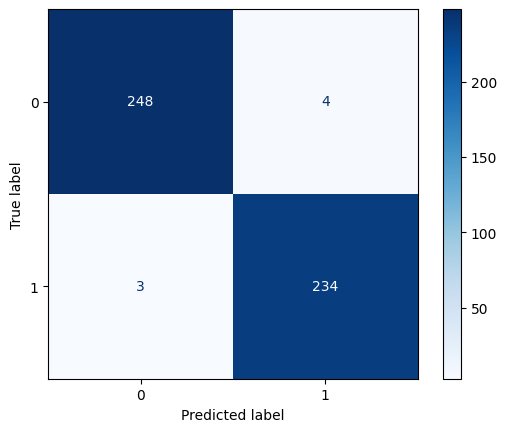

In [195]:
P1_valid = model1_80.predict_proba(valid_emoticon_X_encoded_80)[:, 1]
P2_valid = model2_80.predict_proba(valid_X_deep_flattened_80)[:, 1]

meta_X_valid = np.column_stack((P1_valid,P2_valid))

y_pred_valid_80 = meta_model_80.predict(meta_X_valid)

accuracy_80 = accuracy_score(valid_emoticon_Y, y_pred_valid_80)
conf_matrix = confusion_matrix(valid_emoticon_Y, y_pred_valid_80)

print(f"Validation Accuracy: {accuracy_80*100:.4f}")
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')

## For 60% Training Data

### Feature Transformation and encoding

#### For Emoticon Dataset

##### Transformation

In [196]:
train_emoticon_X_data_60 = [list(input_str) for input_str in train_emoticon_X_60]
train_emoticon_X_data_60 = pd.DataFrame(train_emoticon_X_data_60)
train_emoticon_X_data_60 = train_emoticon_X_data_60.map(ord)
train_emoticon_X_data_60 = train_emoticon_X_data_60.astype(str)
train_emoticon_X_data_60 = train_emoticon_X_data_60.apply(lambda row: ' '.join(row.values), axis=1)
train_emoticon_X_data_60 = pd.DataFrame(train_emoticon_X_data_60, columns=['text'])

In [197]:
valid_emoticon_X_data_60 = [list(input_str) for input_str in valid_emoticon_X]
valid_emoticon_X_data_60 = pd.DataFrame(valid_emoticon_X_data_60)
valid_emoticon_X_data_60 = valid_emoticon_X_data_60.map(ord)
valid_emoticon_X_data_60 = valid_emoticon_X_data_60.astype(str)
valid_emoticon_X_data_60 = valid_emoticon_X_data_60.apply(lambda row: ' '.join(row.values), axis=1)
valid_emoticon_X_data_60 = pd.DataFrame(valid_emoticon_X_data_60, columns=['text'])

##### Embedding

In [198]:
train_df = train_emoticon_X_data_60
valid_df = valid_emoticon_X_data_60

combined_vocab = set()
train_df['tokens'] = train_df['text'].apply(lambda x: x.split())
combined_vocab.update(train_df['tokens'].explode().unique())
print(combined_vocab)
valid_df['tokens'] = valid_df['text'].apply(lambda x: x.split())
combined_vocab.update(valid_df['tokens'].explode().unique())
print(combined_vocab)
vocab_dict_60 = {word: idx for idx, word in enumerate(combined_vocab, start=1)}

def tokenize_data(df, vocab_dict_60):
    return df['tokens'].apply(lambda x: [vocab_dict_60[token] for token in x])

train_df['tokenized_text'] = tokenize_data(train_df, vocab_dict_60)
valid_df['tokenized_text'] = tokenize_data(valid_df, vocab_dict_60)
max_length = 13
train_padded = pad_sequences(train_df['tokenized_text'].tolist(), maxlen=max_length, padding='post')
valid_padded = pad_sequences(valid_df['tokenized_text'].tolist(), maxlen=max_length, padding='post')

embedding_size = 16
vocab_size = len(vocab_dict_60) + 1

input_layer = Input(shape=(max_length,), dtype='int32')
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_length, name='embedding_layer')(input_layer)
lstm_layer = LSTM(16, return_sequences=True)(embedding_layer)
dropout_layer = Dropout(0.2)(lstm_layer)
flatten_layer = Flatten()(dropout_layer)
dense_layer = Dense(8, activation='relu')(flatten_layer)
output_layer = Dense(1, activation='sigmoid')(dense_layer)

model_1_60 = Model(inputs=input_layer, outputs=output_layer, name='small_text_embedding_model')
model_1_60.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_1_60.summary()

train_labels = train_emoticon_Y_60
valid_labels = valid_emoticon_Y
model_1_60.fit(train_padded, train_labels, epochs=6, batch_size=2)

embedding_model_60 = Model(inputs=model_1_60.input, outputs=model_1_60.get_layer("embedding_layer").output)

train_embeddings = embedding_model_60.predict(train_padded)
valid_embeddings = embedding_model_60.predict(valid_padded)

{'128688', '128513', '128641', '128706', '128710', '128628', '128527', '128522', '128653', '128723', '128552', '128558', '128599', '128616', '128524', '128650', '128580', '128619', '128714', '128571', '128679', '128726', '128563', '128667', '128562', '128702', '128735', '128565', '128654', '128525', '128583', '128722', '128548', '128716', '128573', '128676', '128564', '128584', '128517', '128672', '128642', '128570', '128534', '128549', '128708', '128683', '128538', '128697', '128671', '128512', '128660', '128581', '128542', '128680', '128692', '128633', '128725', '128541', '128603', '128689', '128575', '128554', '128597', '128715', '128591', '128559', '128669', '128604', '128569', '128646', '128655', '128727', '128617', '128703', '128731', '128674', '128614', '128544', '128536', '128691', '128553', '128701', '128620', '128675', '128705', '128693', '128514', '128589', '128593', '128719', '128539', '128594', '128630', '128547', '128734', '128613', '128577', '128645', '128713', '128523',

/home/nishvaan/.local/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "small_text_embedding_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_layer (Embedding)     │ (None, 13, 16)         │         3,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 13, 16)         │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 13, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 208)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 8)              │         1,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,233 (28.25 KB)

 Trainable params: 7,233 (28.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/6
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6387 - loss: 0.5757
Epoch 2/6
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9153 - loss: 0.1933
Epoch 3/6
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9422 - loss: 0.1420
Epoch 4/6
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9485 - loss: 0.1264
Epoch 5/6
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9612 - loss: 0.0992
Epoch 6/6
2124/2124 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9597 - loss: 0.0932
133/133 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step


In [199]:
train_emoticon_X_flattened_60 = train_embeddings.reshape(train_embeddings.shape[0], -1)
valid_emoticon_X_flattened_60 = valid_embeddings.reshape(valid_embeddings.shape[0], -1)

train_emoticon_X_encoded_60=pd.DataFrame(train_emoticon_X_flattened_60)
valid_emoticon_X_encoded_60=pd.DataFrame(valid_emoticon_X_flattened_60)

##### Standardization

In [200]:
scaler_60 = StandardScaler()
train_emoticon_X_encoded_60 = scaler_60.fit_transform(train_emoticon_X_encoded_60)
valid_emoticon_X_encoded_60 = scaler_60.transform(valid_emoticon_X_encoded_60)

#### For Deep Feature Dataset

##### Feature Transformation

In [201]:
train_X_deep_flattened_60 = train_deep_X_60.reshape(train_deep_X_60.shape[0], -1)
valid_X_deep_flattened_60 = valid_deep_X.reshape(valid_deep_X.shape[0], -1)

print(train_X_deep_flattened_60.shape)

(4248, 9984)


##### Feature Reduction

In [202]:
pca_60 = PCA(n_components=100)
train_X_deep_flattened_60 = pca_60.fit_transform(train_X_deep_flattened_60)
valid_X_deep_flattened_60 = pca_60.transform(valid_X_deep_flattened_60)

### Model Training

In [203]:
model1_60 = SVC(C=0.1, degree=2, gamma='auto', kernel='rbf', probability=True)
model2_60 = SVC(C=100, degree=2, gamma='auto', kernel='rbf', probability=True)

model1_60.fit(train_emoticon_X_encoded_60, train_emoticon_Y_60)
model2_60.fit(train_X_deep_flattened_60, train_emoticon_Y_60)

P1 = model1_60.predict_proba(train_emoticon_X_encoded_60)[:, 1]
P2 = model2_60.predict_proba(train_X_deep_flattened_60)[:, 1]

meta_X_train = np.column_stack((P1,P2))

meta_model_60 = RandomForestClassifier()
meta_model_60.fit(meta_X_train, train_emoticon_Y_60)

RandomForestClassifier()

### Accuracy Checking

Validation Accuracy: 98.1595


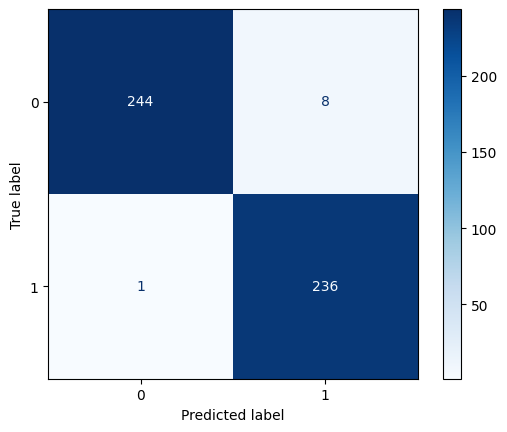

In [204]:
P1_valid = model1_60.predict_proba(valid_emoticon_X_encoded_60)[:, 1]
P2_valid = model2_60.predict_proba(valid_X_deep_flattened_60)[:, 1]

meta_X_valid = np.column_stack((P1_valid,P2_valid))

y_pred_valid_60 = meta_model_60.predict(meta_X_valid)

accuracy_60 = accuracy_score(valid_emoticon_Y, y_pred_valid_60)
conf_matrix = confusion_matrix(valid_emoticon_Y, y_pred_valid_60)

print(f"Validation Accuracy: {accuracy_60*100:.4f}")
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')

## For 40% of Training Data

### Feature Transformation and Encoding

#### For emoticon dataset

##### Transformation

In [205]:
train_emoticon_X_data_40 = [list(input_str) for input_str in train_emoticon_X_40]
train_emoticon_X_data_40 = pd.DataFrame(train_emoticon_X_data_40)
train_emoticon_X_data_40 = train_emoticon_X_data_40.map(ord)
train_emoticon_X_data_40 = train_emoticon_X_data_40.astype(str)
train_emoticon_X_data_40 = train_emoticon_X_data_40.apply(lambda row: ' '.join(row.values), axis=1)
train_emoticon_X_data_40 = pd.DataFrame(train_emoticon_X_data_40, columns=['text'])

In [206]:
valid_emoticon_X_data_40 = [list(input_str) for input_str in valid_emoticon_X]
valid_emoticon_X_data_40 = pd.DataFrame(valid_emoticon_X_data_40)
valid_emoticon_X_data_40 = valid_emoticon_X_data_40.map(ord)
valid_emoticon_X_data_40 = valid_emoticon_X_data_40.astype(str)
valid_emoticon_X_data_40 = valid_emoticon_X_data_40.apply(lambda row: ' '.join(row.values), axis=1)
valid_emoticon_X_data_40 = pd.DataFrame(valid_emoticon_X_data_40, columns=['text'])

##### Embedding

In [207]:
train_df = train_emoticon_X_data_40
valid_df = valid_emoticon_X_data_40

combined_vocab = set()
train_df['tokens'] = train_df['text'].apply(lambda x: x.split())
combined_vocab.update(train_df['tokens'].explode().unique())
print(combined_vocab)
valid_df['tokens'] = valid_df['text'].apply(lambda x: x.split())
combined_vocab.update(valid_df['tokens'].explode().unique())
print(combined_vocab)
vocab_dict_40 = {word: idx for idx, word in enumerate(combined_vocab, start=1)}

def tokenize_data(df, vocab_dict_40):
    return df['tokens'].apply(lambda x: [vocab_dict_40[token] for token in x])

train_df['tokenized_text'] = tokenize_data(train_df, vocab_dict_40)
valid_df['tokenized_text'] = tokenize_data(valid_df, vocab_dict_40)
max_length = 13
train_padded = pad_sequences(train_df['tokenized_text'].tolist(), maxlen=max_length, padding='post')
valid_padded = pad_sequences(valid_df['tokenized_text'].tolist(), maxlen=max_length, padding='post')

embedding_size = 16
vocab_size = len(vocab_dict_40) + 1

input_layer = Input(shape=(max_length,), dtype='int32')
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_length, name='embedding_layer')(input_layer)
lstm_layer = LSTM(16, return_sequences=True)(embedding_layer)
dropout_layer = Dropout(0.2)(lstm_layer)
flatten_layer = Flatten()(dropout_layer)
dense_layer = Dense(8, activation='relu')(flatten_layer)
output_layer = Dense(1, activation='sigmoid')(dense_layer)

model_1_40 = Model(inputs=input_layer, outputs=output_layer, name='small_text_embedding_model')
model_1_40.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_1_40.summary()

train_labels = train_emoticon_Y_40
valid_labels = valid_emoticon_Y
model_1_40.fit(train_padded, train_labels, epochs=6, batch_size=2)

embedding_model_40 = Model(inputs=model_1_40.input, outputs=model_1_40.get_layer("embedding_layer").output)

train_embeddings = embedding_model_40.predict(train_padded)
valid_embeddings = embedding_model_40.predict(valid_padded)

{'128513', '128641', '128688', '128706', '128710', '128628', '128527', '128653', '128522', '128723', '128552', '128599', '128558', '128524', '128616', '128650', '128580', '128679', '128571', '128619', '128714', '128726', '128563', '128667', '128562', '128702', '128565', '128735', '128654', '128583', '128525', '128722', '128548', '128716', '128573', '128676', '128564', '128584', '128517', '128672', '128642', '128570', '128534', '128549', '128708', '128683', '128538', '128697', '128671', '128512', '128660', '128581', '128542', '128680', '128692', '128633', '128725', '128541', '128603', '128689', '128575', '128554', '128597', '128715', '128591', '128559', '128669', '128604', '128569', '128646', '128655', '128727', '128617', '128703', '128731', '128674', '128614', '128544', '128536', '128691', '128553', '128701', '128620', '128675', '128514', '128693', '128705', '128593', '128589', '128719', '128539', '128594', '128630', '128547', '128734', '128645', '128577', '128613', '128713', '128523',

/home/nishvaan/.local/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "small_text_embedding_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_layer (Embedding)     │ (None, 13, 16)         │         3,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 13, 16)         │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 13, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 208)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 8)              │         1,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,233 (28.25 KB)

 Trainable params: 7,233 (28.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/6
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6045 - loss: 0.6100
Epoch 2/6
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9183 - loss: 0.1867
Epoch 3/6
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9391 - loss: 0.1486
Epoch 4/6
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9489 - loss: 0.1343
Epoch 5/6
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9533 - loss: 0.1099
Epoch 6/6
1416/1416 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9633 - loss: 0.0952
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step


In [208]:
train_emoticon_X_flattened_40 = train_embeddings.reshape(train_embeddings.shape[0], -1)
valid_emoticon_X_flattened_40 = valid_embeddings.reshape(valid_embeddings.shape[0], -1)

train_emoticon_X_encoded_40=pd.DataFrame(train_emoticon_X_flattened_40)
valid_emoticon_X_encoded_40=pd.DataFrame(valid_emoticon_X_flattened_40)

##### Standardization

In [209]:
scaler_40 = StandardScaler()
train_emoticon_X_encoded_40 = scaler_40.fit_transform(train_emoticon_X_encoded_40)
valid_emoticon_X_encoded_40 = scaler_40.transform(valid_emoticon_X_encoded_40)

#### For Deep Feature Dataset

##### Feature Transformation

In [210]:
train_X_deep_flattened_40 = train_deep_X_40.reshape(train_deep_X_40.shape[0], -1)
valid_X_deep_flattened_40 = valid_deep_X.reshape(valid_deep_X.shape[0], -1)

print(train_X_deep_flattened_40.shape)

(2832, 9984)


##### Feature Reduction

In [211]:
pca_40 = PCA(n_components=100)
train_X_deep_flattened_40 = pca_40.fit_transform(train_X_deep_flattened_40)
valid_X_deep_flattened_40 = pca_40.transform(valid_X_deep_flattened_40)

### Model Training

In [212]:
model1_40 = SVC(C=0.1, degree=2, gamma='auto', kernel='rbf', probability=True)
model2_40 = SVC(C=100, degree=2, gamma='auto', kernel='rbf', probability=True)

model1_40.fit(train_emoticon_X_encoded_40, train_emoticon_Y_40)
model2_40.fit(train_X_deep_flattened_40, train_emoticon_Y_40)

P1 = model1_40.predict_proba(train_emoticon_X_encoded_40)[:, 1]
P2 = model2_40.predict_proba(train_X_deep_flattened_40)[:, 1]

meta_X_train = np.column_stack((P1,P2))

meta_model_40 = RandomForestClassifier()
meta_model_40.fit(meta_X_train, train_emoticon_Y_40)

RandomForestClassifier()

### Accuracy Checking

Validation Accuracy: 96.9325


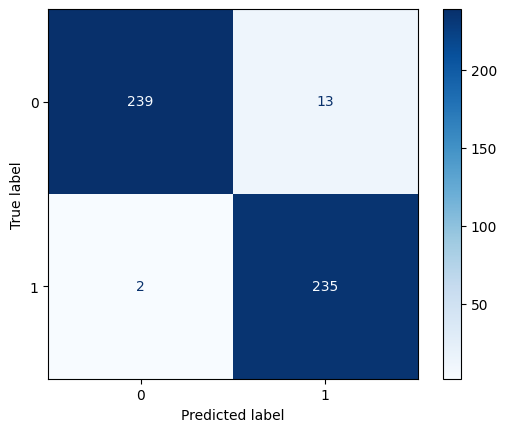

In [213]:
P1_valid = model1_40.predict_proba(valid_emoticon_X_encoded_40)[:, 1]
P2_valid = model2_40.predict_proba(valid_X_deep_flattened_40)[:, 1]

meta_X_valid = np.column_stack((P1_valid,P2_valid))

y_pred_valid_40 = meta_model_40.predict(meta_X_valid)

accuracy_40 = accuracy_score(valid_emoticon_Y, y_pred_valid_40)
conf_matrix = confusion_matrix(valid_emoticon_Y, y_pred_valid_40)

print(f"Validation Accuracy: {accuracy_40*100:.4f}")
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')

## For 20% of Training Data

### Feature transformation and Encoding

#### For Emoticon Dataset

##### Transformation

In [214]:
train_emoticon_X_data_20 = [list(input_str) for input_str in train_emoticon_X_20]
train_emoticon_X_data_20 = pd.DataFrame(train_emoticon_X_data_20)
train_emoticon_X_data_20 = train_emoticon_X_data_20.map(ord)
train_emoticon_X_data_20 = train_emoticon_X_data_20.astype(str)
train_emoticon_X_data_20 = train_emoticon_X_data_20.apply(lambda row: ' '.join(row.values), axis=1)
train_emoticon_X_data_20 = pd.DataFrame(train_emoticon_X_data_20, columns=['text'])

In [215]:
valid_emoticon_X_data_20 = [list(input_str) for input_str in valid_emoticon_X]
valid_emoticon_X_data_20 = pd.DataFrame(valid_emoticon_X_data_20)
valid_emoticon_X_data_20 = valid_emoticon_X_data_20.map(ord)
valid_emoticon_X_data_20 = valid_emoticon_X_data_20.astype(str)
valid_emoticon_X_data_20 = valid_emoticon_X_data_20.apply(lambda row: ' '.join(row.values), axis=1)
valid_emoticon_X_data_20 = pd.DataFrame(valid_emoticon_X_data_20, columns=['text'])

##### Embedding

In [216]:
train_df = train_emoticon_X_data_20
valid_df = valid_emoticon_X_data_20

combined_vocab = set()
train_df['tokens'] = train_df['text'].apply(lambda x: x.split())
combined_vocab.update(train_df['tokens'].explode().unique())
print(combined_vocab)
valid_df['tokens'] = valid_df['text'].apply(lambda x: x.split())
combined_vocab.update(valid_df['tokens'].explode().unique())
print(combined_vocab)
vocab_dict_20 = {word: idx for idx, word in enumerate(combined_vocab, start=1)}

def tokenize_data(df, vocab_dict_20):
    return df['tokens'].apply(lambda x: [vocab_dict_20[token] for token in x])

train_df['tokenized_text'] = tokenize_data(train_df, vocab_dict_20)
valid_df['tokenized_text'] = tokenize_data(valid_df, vocab_dict_20)
max_length = 13
train_padded = pad_sequences(train_df['tokenized_text'].tolist(), maxlen=max_length, padding='post')
valid_padded = pad_sequences(valid_df['tokenized_text'].tolist(), maxlen=max_length, padding='post')

embedding_size = 16
vocab_size = len(vocab_dict_20) + 1

input_layer = Input(shape=(max_length,), dtype='int32')
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_length, name='embedding_layer')(input_layer)
lstm_layer = LSTM(16, return_sequences=True)(embedding_layer)
dropout_layer = Dropout(0.2)(lstm_layer)
flatten_layer = Flatten()(dropout_layer)
dense_layer = Dense(8, activation='relu')(flatten_layer)
output_layer = Dense(1, activation='sigmoid')(dense_layer)

model_1_20 = Model(inputs=input_layer, outputs=output_layer, name='small_text_embedding_model')
model_1_20.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_1_20.summary()

train_labels = train_emoticon_Y_20
valid_labels = valid_emoticon_Y
model_1_20.fit(train_padded, train_labels, epochs=6, batch_size=2)

embedding_model_20 = Model(inputs=model_1_20.input, outputs=model_1_20.get_layer("embedding_layer").output)

train_embeddings = embedding_model_20.predict(train_padded)
valid_embeddings = embedding_model_20.predict(valid_padded)

{'128513', '128688', '128641', '128706', '128710', '128628', '128527', '128522', '128653', '128723', '128552', '128599', '128558', '128616', '128524', '128650', '128619', '128679', '128571', '128580', '128714', '128726', '128563', '128667', '128562', '128702', '128565', '128735', '128654', '128525', '128583', '128722', '128548', '128716', '128573', '128676', '128564', '128584', '128517', '128672', '128642', '128570', '128534', '128549', '128708', '128683', '128538', '128671', '128697', '128512', '128660', '128581', '128542', '128680', '128692', '128633', '128725', '128541', '128603', '128689', '128575', '128554', '128597', '128715', '128591', '128559', '128669', '128604', '128569', '128646', '128655', '128727', '128617', '128703', '128731', '128674', '128614', '128544', '128536', '128691', '128553', '128701', '128620', '128675', '128514', '128705', '128693', '128589', '128593', '128719', '128539', '128594', '128630', '128547', '128734', '128613', '128645', '128577', '128713', '128523',

/home/nishvaan/.local/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "small_text_embedding_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_layer (Embedding)     │ (None, 13, 16)         │         3,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 13, 16)         │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 13, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 208)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 8)              │         1,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,233 (28.25 KB)

 Trainable params: 7,233 (28.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/6
708/708 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5031 - loss: 0.6887
Epoch 2/6
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8584 - loss: 0.3321
Epoch 3/6
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8971 - loss: 0.2175
Epoch 4/6
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9398 - loss: 0.1513
Epoch 5/6
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9543 - loss: 0.1184
Epoch 6/6
708/708 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9636 - loss: 0.0998
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [217]:
train_emoticon_X_flattened_20 = train_embeddings.reshape(train_embeddings.shape[0], -1)
valid_emoticon_X_flattened_20 = valid_embeddings.reshape(valid_embeddings.shape[0], -1)

train_emoticon_X_encoded_20=pd.DataFrame(train_emoticon_X_flattened_20)
valid_emoticon_X_encoded_20=pd.DataFrame(valid_emoticon_X_flattened_20)

##### Standardization

In [218]:
scaler_20 = StandardScaler()
train_emoticon_X_encoded_20 = scaler_20.fit_transform(train_emoticon_X_encoded_20)
valid_emoticon_X_encoded_20 = scaler_20.transform(valid_emoticon_X_encoded_20)

#### For Deep Feature Dataset 

##### Feature transformation

In [219]:
train_X_deep_flattened_20 = train_deep_X_20.reshape(train_deep_X_20.shape[0], -1)
valid_X_deep_flattened_20 = valid_deep_X.reshape(valid_deep_X.shape[0], -1)

print(train_X_deep_flattened_20.shape)

(1416, 9984)


##### Feature Reduction

In [220]:
pca_20 = PCA(n_components=100)
train_X_deep_flattened_20 = pca_20.fit_transform(train_X_deep_flattened_20)
valid_X_deep_flattened_20 = pca_20.transform(valid_X_deep_flattened_20)

### Model Training

In [221]:
model1_20 = SVC(C=0.1, degree=2, gamma='auto', kernel='rbf', probability=True)
model2_20 = SVC(C=100, degree=2, gamma='auto', kernel='rbf', probability=True)

model1_20.fit(train_emoticon_X_encoded_20, train_emoticon_Y_20)
model2_20.fit(train_X_deep_flattened_20, train_emoticon_Y_20)

P1 = model1_20.predict_proba(train_emoticon_X_encoded_20)[:, 1]
P2 = model2_20.predict_proba(train_X_deep_flattened_20)[:, 1]

meta_X_train = np.column_stack((P1,P2))

meta_model_20 = RandomForestClassifier()
meta_model_20.fit(meta_X_train, train_emoticon_Y_20)

RandomForestClassifier()

### Accuracy Checking

Validation Accuracy: 96.7280


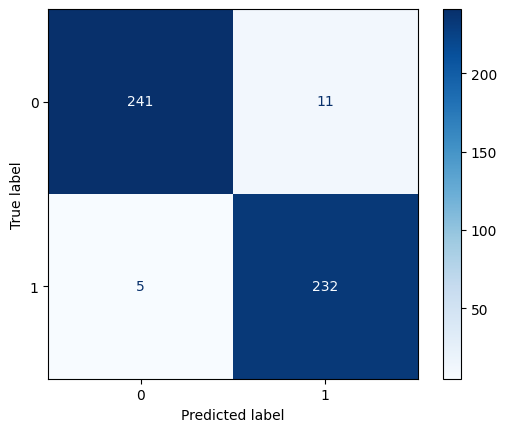

In [222]:
P1_valid = model1_20.predict_proba(valid_emoticon_X_encoded_20)[:, 1]
P2_valid = model2_20.predict_proba(valid_X_deep_flattened_20)[:, 1]

meta_X_valid = np.column_stack((P1_valid,P2_valid))

y_pred_valid_20 = meta_model_20.predict(meta_X_valid)

accuracy_20 = accuracy_score(valid_emoticon_Y, y_pred_valid_20)
conf_matrix = confusion_matrix(valid_emoticon_Y, y_pred_valid_20)

print(f"Validation Accuracy: {accuracy_20*100:.4f}")
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')

## Accuracy Variation plot for different % of data

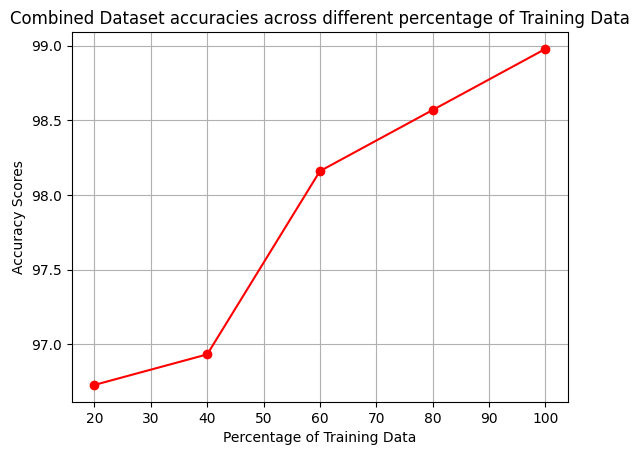

In [231]:
accuracy_scores = [accuracy_20*100, accuracy_40*100, accuracy_60*100, accuracy_80*100, accuracy_100*100]
percentage_of_data = [20, 40, 60, 80, 100]

plt.plot(percentage_of_data, accuracy_scores, color='red', marker='o')

plt.title('Combined Dataset accuracies across different percentage of Training Data')
plt.xlabel('Percentage of Training Data')
plt.ylabel('Accuracy Scores')

# plt.ylim([91, 98])

plt.grid(True)
plt.show()

## Prediction for Test Data

In [224]:
test_emoticon_df=pd.read_csv("datasets/test/test_emoticon.csv")
test_emoticon_X = test_emoticon_df['input_emoticon']

test_emoticon_X_data = [list(input_str) for input_str in test_emoticon_X]
test_emoticon_X_data = pd.DataFrame(test_emoticon_X_data)
test_emoticon_X_data = test_emoticon_X_data.map(ord)
test_emoticon_X_data = test_emoticon_X_data.astype(str)
test_emoticon_X_data = test_emoticon_X_data.apply(lambda row: ' '.join(row.values), axis=1)
test_emoticon_X_data = pd.DataFrame(test_emoticon_X_data, columns=['text'])

In [225]:
test_df = test_emoticon_X_data
test_df['tokens'] = test_df['text'].apply(lambda x: x.split())
def tokenize_test_data(df, vocab_dict_100):
    return df['tokens'].apply(lambda x: [vocab_dict_100[token] if token in vocab_dict_100 else 0 for token in x])
test_df['tokenized_text'] = tokenize_test_data(test_df, vocab_dict_100)
test_padded = pad_sequences(test_df['tokenized_text'].tolist(), maxlen=max_length, padding='post')
test_embeddings = embedding_model_100.predict(test_padded)
print("Test Embeddings Shape:", test_embeddings.shape)
test_emoticon_X_flattened = test_embeddings.reshape(test_embeddings.shape[0], -1)
test_emoticon_X_encoded=pd.DataFrame(test_emoticon_X_flattened)
test_emoticon_X_encoded = scaler_100.transform(test_emoticon_X_encoded)

70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
Test Embeddings Shape: (2232, 13, 16)


In [226]:
test_data = np.load('datasets/test/test_feature.npz', allow_pickle=True)
test_deep_X = test_data['features']

test_X_deep_flattened = test_deep_X.reshape(test_deep_X.shape[0], -1)
test_X_deep_flattened = pca_100.transform(test_X_deep_flattened)

In [227]:
P1_test = model1_100.predict_proba(test_emoticon_X_encoded)[:, 1]
P2_test = model2_100.predict_proba(test_X_deep_flattened)[:, 1]

meta_X_test = np.column_stack((P1_test,P2_test))

y_pred_test = meta_model_100.predict(meta_X_test)

np.savetxt("pred_combined.txt", y_pred_test, fmt="%d", delimiter="\n")